# This File loads in the datasets and tests convexity of the masks
- Currently being ran with both the updated cropped (300 x 400) Band Contrast images as well as the (300 x 400) Kaggle images to see their potential
- Determines the ability to utilize a dataset based on its convexity of objects as well as the labeled images reconstruction through a variety of different rays

---
- **Conclusions made:**

  - Kaggle dataset needs more preprocessing even post-Segmentation Anything Model for creating the masks. Objects still remain far from convex in nature and may be due to stardists interpretation of the masked annotations themselves. Requires attention.
  - Therefore, for current testing only the annotations made manually on the Band Contrast image remain viable for training.
---



# Data
- This notebook show how the training data for our model will look like and whether the annotated objects can be appropriately described by star-convex polygons.

- The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

from skimage import io
import os

np.random.seed(42)
lbl_cmap = random_label_cmap()


# This section defines the directory mapping
- **IMPORTATNT NOTE:** If your data is in a different directory structure update it in `dir_map`
---

In [ ]:
import os

dir_map = {
    'BC_IMAGES_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/images',
    'BC_MASKS_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/masks',
    'KAGGLE_IMAGES_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/images',
    'KAGGLE_MASKS_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks',
}

# Used Primarily for Output Directory (Preferably not made yet), Raw Images folders need to have images to process
for _, path in dir_map.items():
    dir = os.getcwd() + '/' + path
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Directory "{str(dir)}" created')
    else:
        print(f'Directory "{str(dir)}" already exists')

Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/images" created
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/masks" created
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/images" created
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/kaggleData/train/masks" created


# Check loaded datasets

Import the data from DataCollection folder

---


In [ ]:
# Get the sorted list of image file paths
BC_image_paths = sorted(glob(dir_map['BC_IMAGES_DIR'] + '/*.tif'))
KAGGLE_image_paths = sorted(glob(dir_map['KAGGLE_IMAGES_DIR'] + '/*.tif'))

# Get the sorted list of mask file paths
BC_mask_paths = sorted(glob(dir_map['BC_MASKS_DIR'] + '/*.tif'))
KAGGLE_mask_paths = sorted(glob(dir_map['KAGGLE_MASKS_DIR'] + '/*.tif'))

# Read the images and masks into arrays
BC_IMAGE_ARR = [io.imread(image_path) for image_path in BC_image_paths]
BC_MASK_ARR = [io.imread(mask_path) for mask_path in BC_mask_paths]

KAGGLE_IMAGE_ARR = [io.imread(image_path) for image_path in KAGGLE_image_paths]
KAGGLE_MASK_ARR = [io.imread(mask_path) for mask_path in KAGGLE_mask_paths]

print("Length of BC Images:", len(BC_IMAGE_ARR))
print("Length of BC Masks:", len(BC_MASK_ARR))

print("Length of KAGGLE Images:", len(KAGGLE_IMAGE_ARR))
print("Length of KAGGLE Masks:", len(KAGGLE_MASK_ARR))

Length of BC Images: 55
Length of BC Masks: 55
Length of KAGGLE Images: 233
Length of KAGGLE Masks: 233


Load only a small subset of each

In [ ]:
BC_IMAGE_ARR, BC_MASK_ARR = BC_IMAGE_ARR[:10], BC_MASK_ARR[:10]
KAGGLE_IMAGE_ARR, KAGGLE_MASK_ARR = KAGGLE_IMAGE_ARR[:10], KAGGLE_MASK_ARR[:10]

In [ ]:
print("Length of BC Images:", len(BC_IMAGE_ARR))
print("Length of BC Masks:", len(BC_MASK_ARR))

print("Length of KAGGLE Images:", len(KAGGLE_IMAGE_ARR))
print("Length of KAGGLE Masks:", len(KAGGLE_MASK_ARR))

Length of BC Images: 10
Length of BC Masks: 10
Length of KAGGLE Images: 10
Length of KAGGLE Masks: 10


# Now print some images

In [ ]:
i = min(3, len(BC_IMAGE_ARR)-1)
img, lbl = BC_IMAGE_ARR[i], BC_MASK_ARR[i]

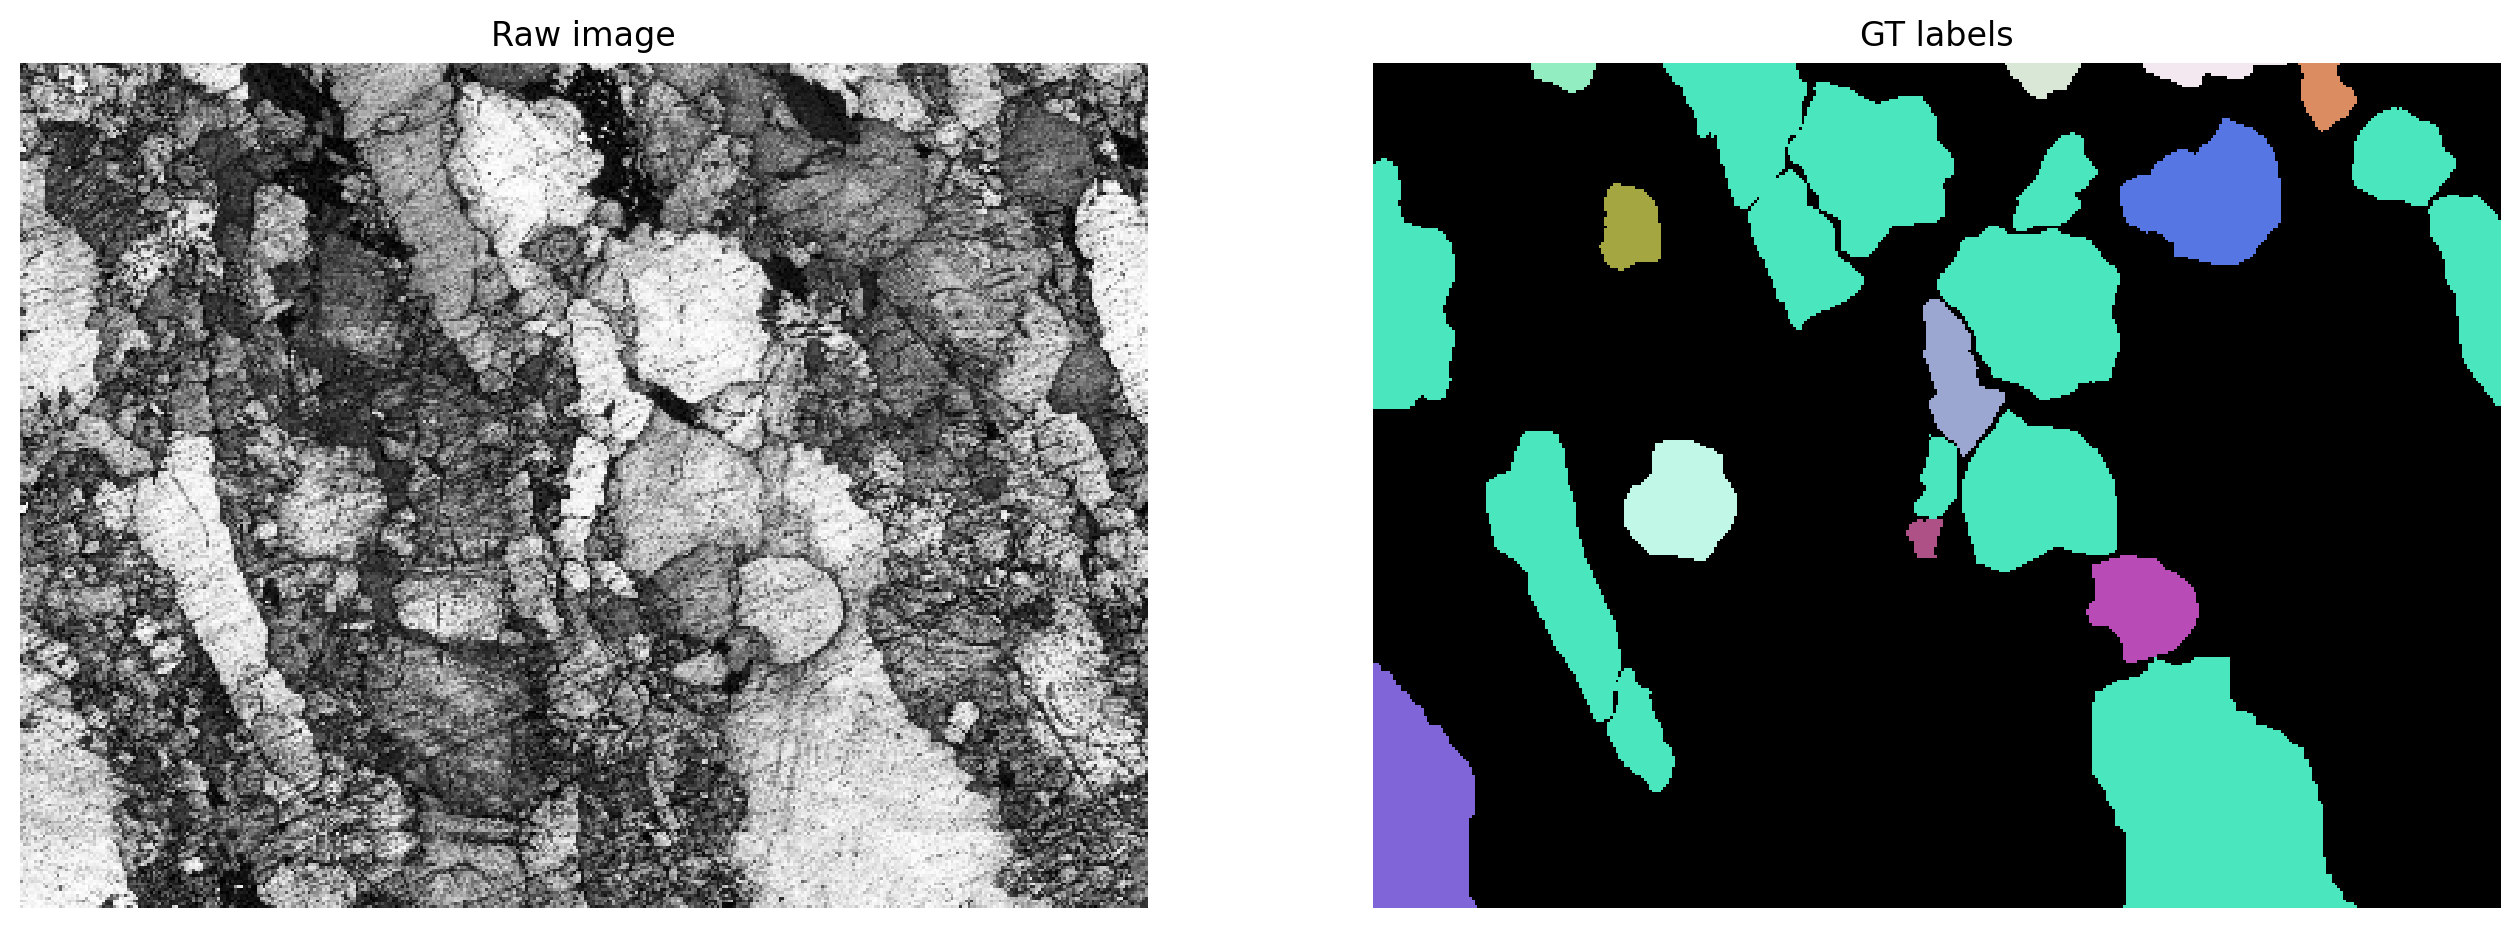

In [ ]:
# Now you can display the images
plt.figure(figsize=(16, 10))
plt.subplot(121); plt.imshow(img, cmap='gray'); plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl, cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.show()

In [ ]:
i = 3
img, lbl = KAGGLE_IMAGE_ARR[i], KAGGLE_MASK_ARR[i]

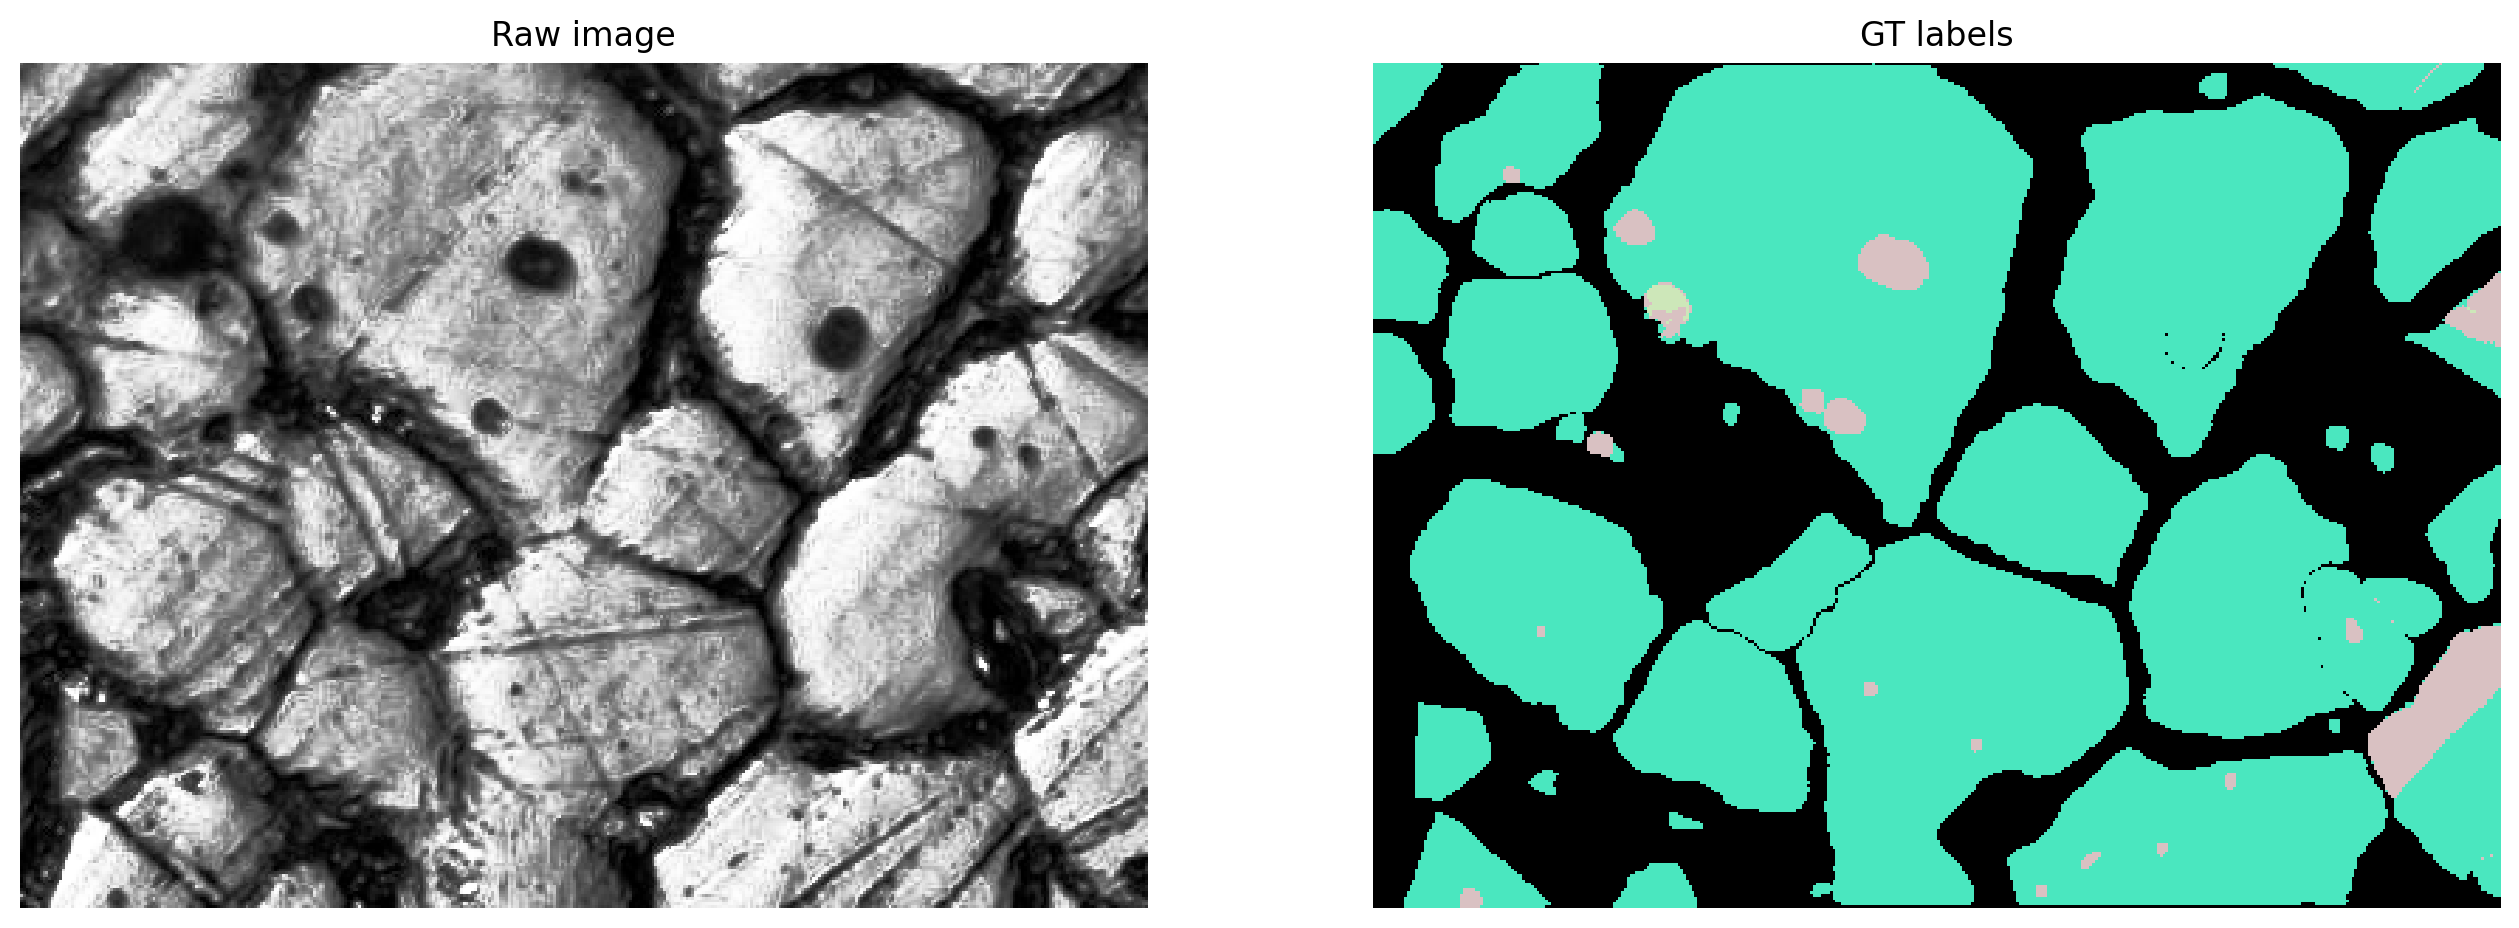

In [ ]:
# Now you can display the images
plt.figure(figsize=(16, 10))
plt.subplot(121); plt.imshow(img, cmap='gray'); plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl, cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.show()

# Fitting ground-truth labels with star-convex polygons

**First try the Band Contrast images**

In [ ]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in BC_MASK_ARR]
    mean_iou = matching_dataset(BC_MASK_ARR, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:35<00:00,  5.98s/it]


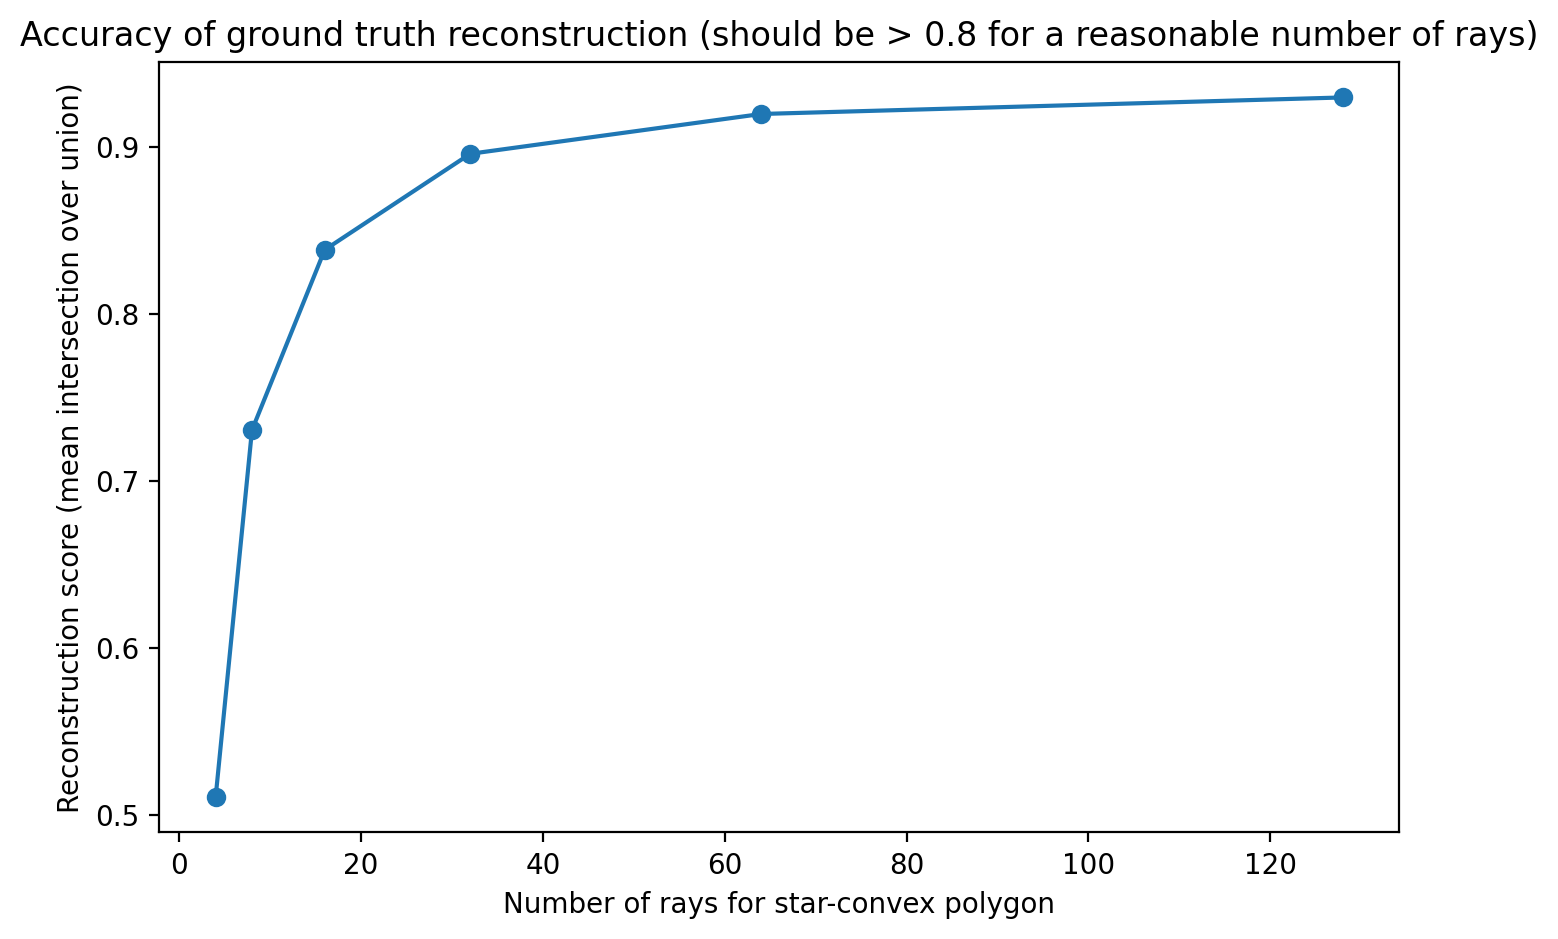

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

**Now try the Kaggle images**

In [ ]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in KAGGLE_MASK_ARR]
    mean_iou = matching_dataset(KAGGLE_MASK_ARR, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:33<00:00,  5.60s/it]


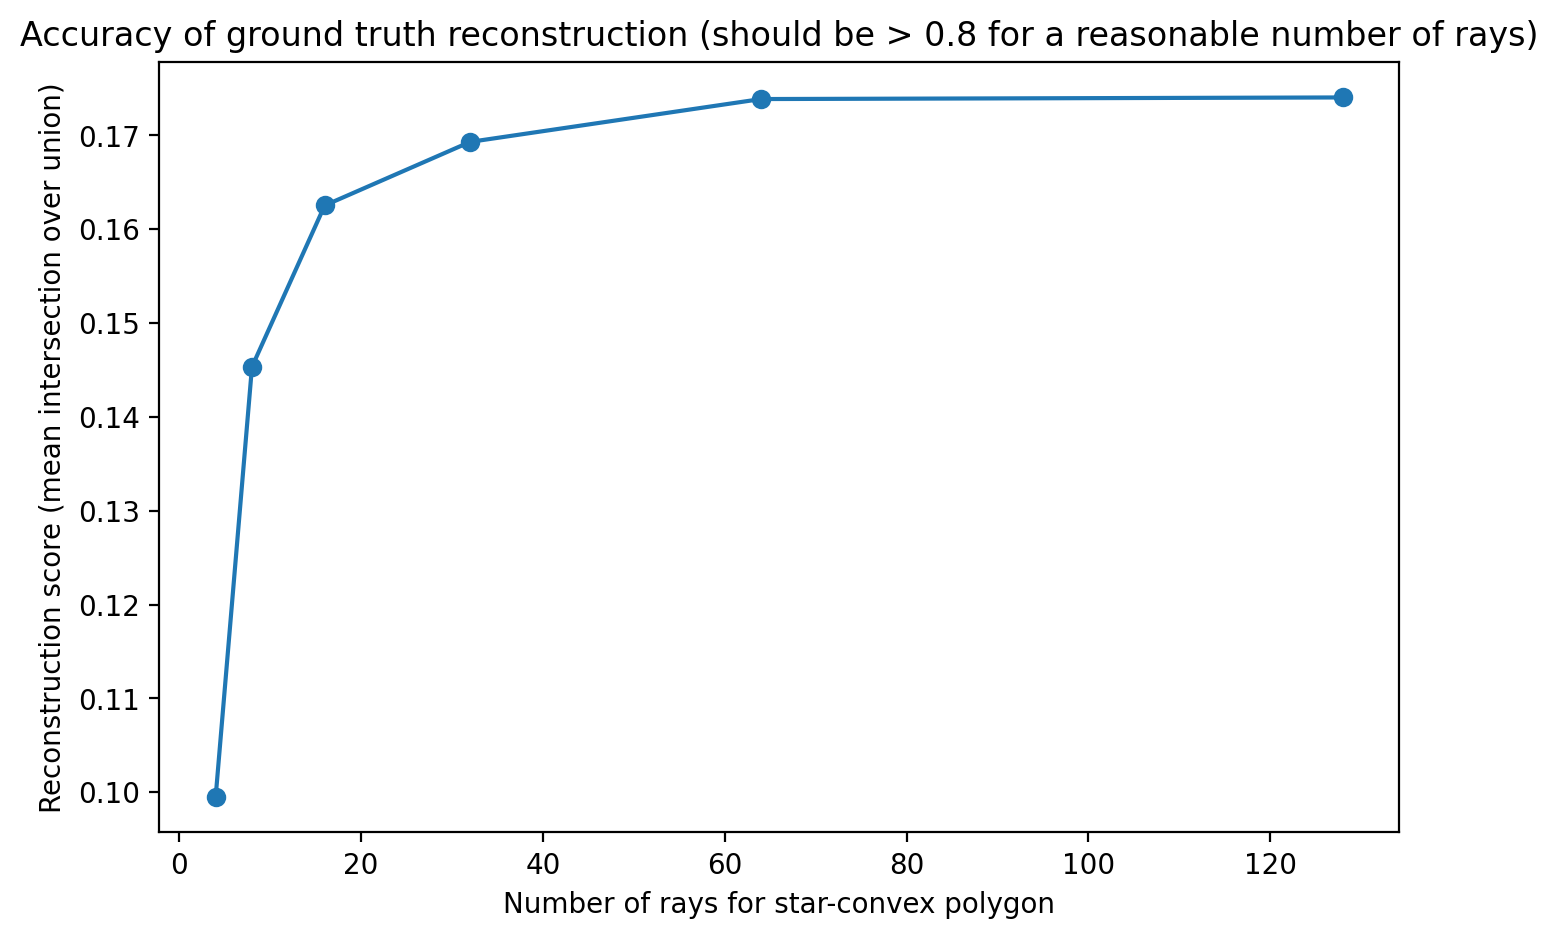

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

## Example image reconstructed with various number of rays

**Try with BC mask**

Label image is at index: 3


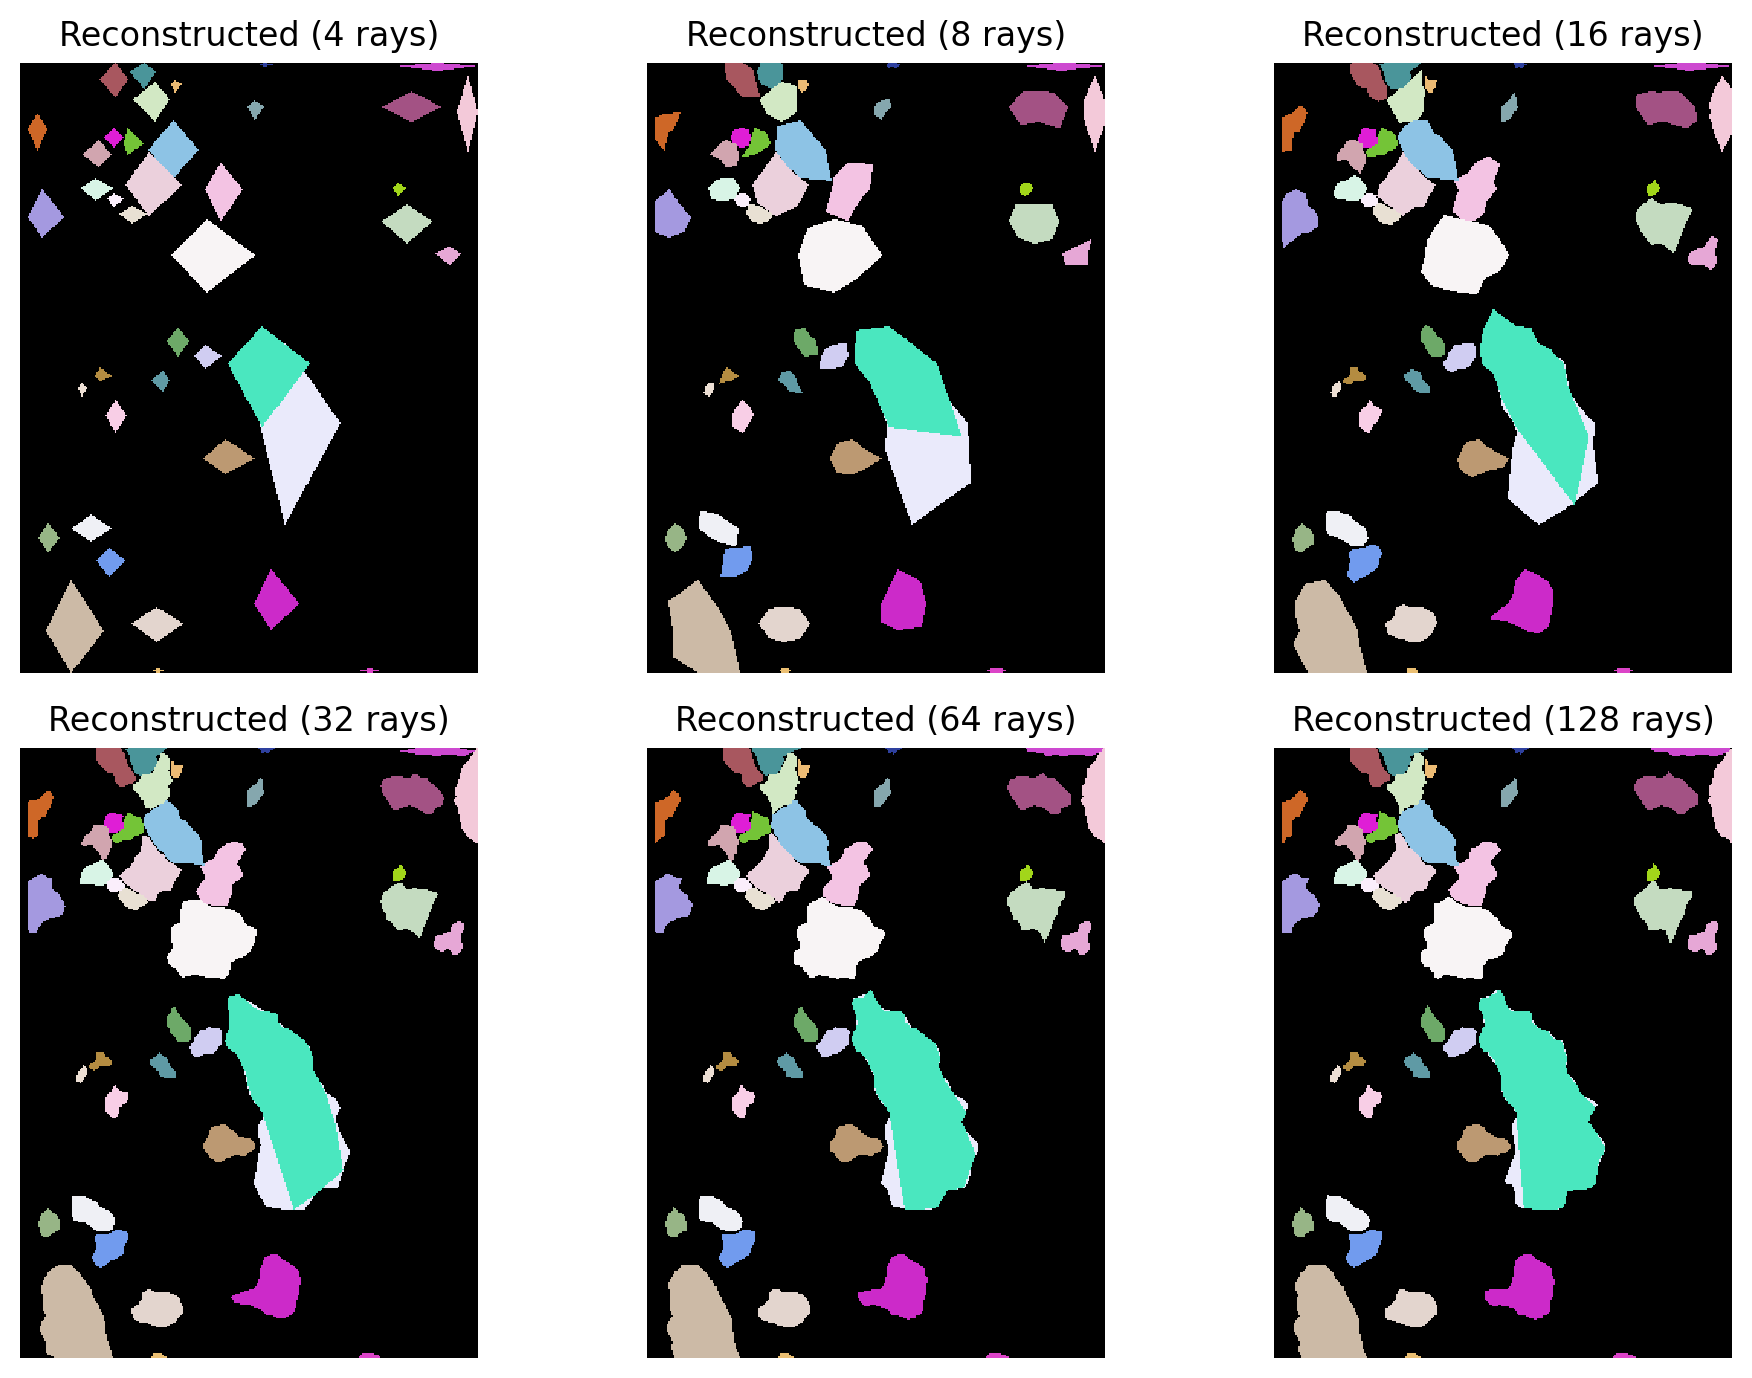

In [ ]:
# Find the index of lbl in Y using array comparison
lbl_index = None
for i, y in enumerate(BC_MASK_ARR):
    if np.array_equal(lbl, y):
        lbl_index = i
        break

if lbl_index is not None:
    print("Label image is at index:", lbl_index)

    # Plotting code with the found index
    fig, ax = plt.subplots(2, 3, figsize=(10, 7))
    for a, r in zip(ax.flat, n_rays):
        a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
        a.set_title(f'Reconstructed ({r} rays)')
        a.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Label image not found in Y")

**Try with Kaggle mask**

Label image is at index: 3


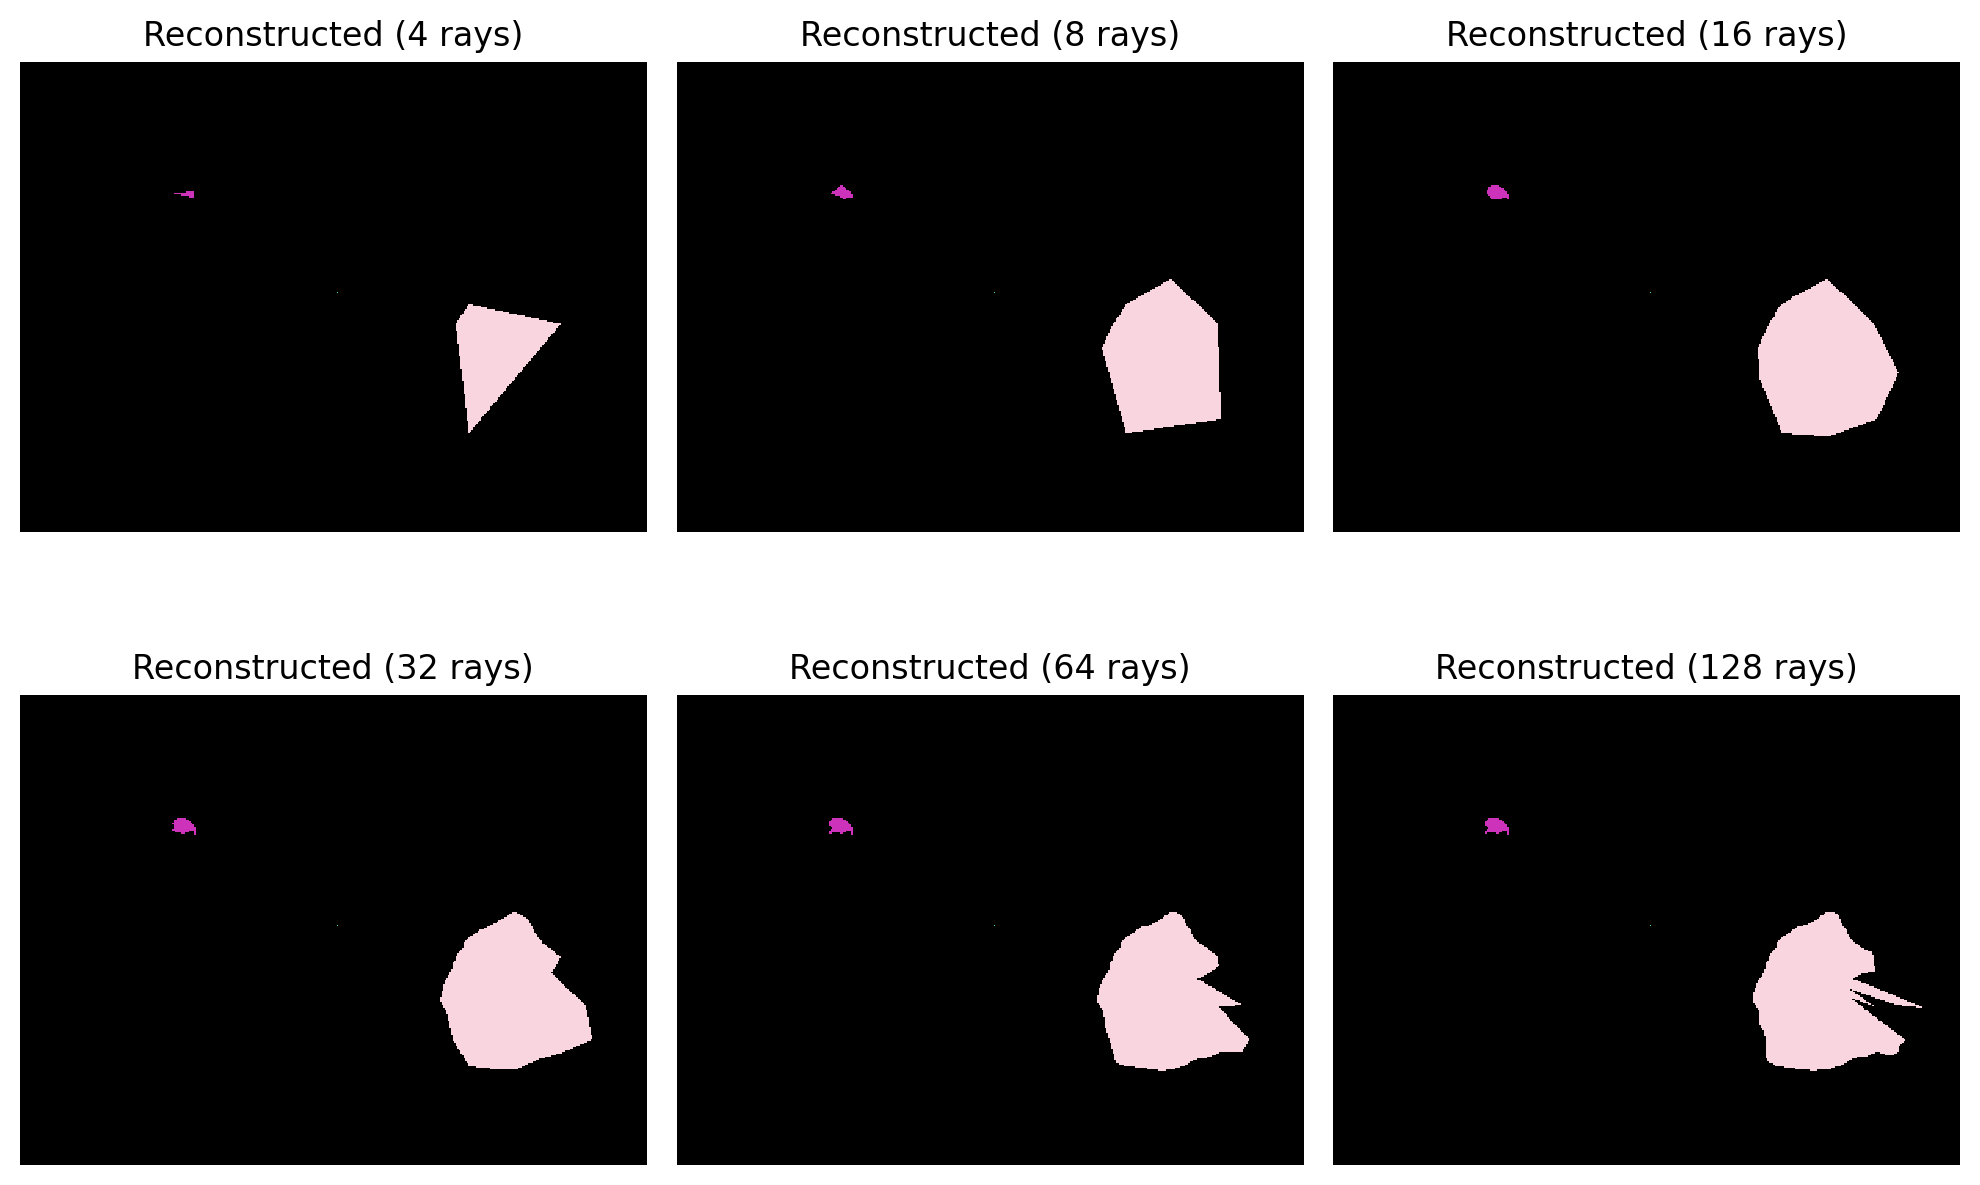

In [ ]:
# Find the index of lbl in Y using array comparison
lbl_index = None
for i, y in enumerate(KAGGLE_MASK_ARR):
    if np.array_equal(lbl, y):
        lbl_index = i
        break

if lbl_index is not None:
    print("Label image is at index:", lbl_index)

    # Plotting code with the found index
    fig, ax = plt.subplots(2, 3, figsize=(10, 7))
    for a, r in zip(ax.flat, n_rays):
        a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
        a.set_title(f'Reconstructed ({r} rays)')
        a.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Label image not found in Y")